In [2]:
import math
import numpy as np
import gerrychain
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd
import pandas as pd
import gurobipy as gp
import csv
import time
import json
import sys
import os

from datetime import date
from gurobipy import GRB 
from gerrychain import Graph
# Reading in our shapefile
fp = "/Users/patrickcummins/Desktop/Thesis/Data/County Data Files/North_Carolina_State_and_County_Boundary_Polygons/North_Carolina_State_and_County_Boundary_Polygons.shp"
data2 = gpd.read_file(fp)
# Reading in demographics information

In [3]:
fp2 = "/Users/patrickcummins/Desktop/Thesis/split_counties.shp"
data = gpd.read_file(fp2)

In [4]:
def update_county_names(dataa, county_name):
    # Filter the GeoDataFrame for the specific county
    county_rows = data[data['County'] == county_name]
    # Generate new names based on the number of parts
    new_names = [f"{county_name}{i + 1}" for i in range(len(county_rows))]
    # Assign new names to the 'County' column
    data.loc[county_rows.index, 'County'] = new_names

# Update names for each divided county
divided_counties = ['Wake', 'Mecklenburg']  # List of counties you divided
for county in divided_counties:
    update_county_names(data, county)

# Check the updated GeoDataFrame
print(data[['County']])

           County
0    Mecklenburg1
1    Mecklenburg2
2    Mecklenburg3
3    Mecklenburg4
4           Wake1
..            ...
101         Surry
102      Hertford
103        Stokes
104          Ashe
105     Alleghany

[106 rows x 1 columns]


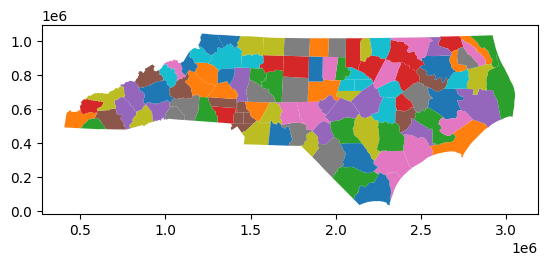

In [5]:
import matplotlib.pyplot as plt
data.plot(column='County')
plt.show()

In [6]:
import pandas as pd
import geopandas as gpd
from gerrychain import Graph

# Load demographic data
demographics = pd.read_csv('/Users/patrickcummins/Desktop/Thesis/Data/Demographics.csv')
demographics_to_merge = demographics[['County Name', 'Population']]
demographics_to_merge = demographics_to_merge.rename(columns={'County Name': 'County', 'Population': 'Population'})
demographics_to_merge['Population'] = demographics_to_merge['Population'].str.replace(',', '').astype(int)

# Merge demographic data
data = data.merge(demographics_to_merge, on='County', how = 'left')
data['County'] = data['County'].str.upper()
data

,OBJECTID,County,FIPS,Rec_Survey,NCGS_url,ck_date,Shape__Are,Shape__Len,GlobalID,POLY_ID,UNIQUE_ID,AREA,POINTX,POINTY,layer,path,geometry,Population
0,41,MECKLENBURG1,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,0.0,05a9a05b-330e-47b8-a645-eae3577abc03,3.800632e+09,1458675.0,487562.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1388233.409 514485.550, 1515936.875 ...",NaN
1,41,MECKLENBURG2,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,1.0,2e0d52fb-9f76-4f62-9f31-7dc72c2b2177,3.800632e+09,1428617.0,548035.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 581637.830, 1457571.965 ...",NaN
2,41,MECKLENBURG3,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,2.0,81cc55fa-914f-4080-bb77-9448c1f80bcc,3.800632e+09,1486804.0,548082.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 514485.550, 1457571.965 ...",NaN
3,41,MECKLENBURG4,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,3.0,2b9e3f2e-b7a0-4da2-8d90-cd4c416f3046,3.800632e+09,1446885.0,614702.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1496097.717 581637.830, 1409154.864 ...",NaN
4,7,WAKE1,183,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2018-12-17,2.388831e+10,702026.273700,c53dafea-2f5d-4fc6-b702-87c714f6a875,0.0,399c97a7-c8e6-4a83-ac2f-4af0dd41c5a7,5.972078e+09,2062361.0,675728.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Wake_divi...,"POLYGON ((2010567.178 707335.610, 2152866.971 ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,96,SURRY,171,No recent survey data available,None,2011-11-29,1.499126e+10,575219.788947,b16703ae-38b8-4e5a-89bc-0df95c91fc07,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1571704.793 909917.753, 1571628.114 ...",71283.0
102,97,HERTFORD,091,No recent survey data available,None,2011-11-29,1.004846e+10,588862.054851,288b0028-fa86-4b36-99d4-1b0e40c573f5,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((2676280.815 915462.441, 2676179.764 ...",19365.0
103,98,STOKES,169,No recent survey data available,None,2011-11-29,1.270900e+10,453418.519272,19c14f88-a2b2-4fbe-ac8a-58396a51cbae,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1694794.027 914115.524, 1694692.600 ...",45205.0
104,99,ASHE,009,No recent survey data available,None,2011-11-29,1.193919e+10,520045.398397,af0b3578-18ca-468a-be2b-dc3958db6c4f,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1269410.478 915476.443, 1266824.413 ...",26685.0


In [7]:
wake_pop_new = round(float(1189705 / 4))
meck_pop_new = round(float(1159791 / 4))

In [8]:
split_counties = ['WAKE1', 'WAKE2', 'WAKE3', 'WAKE4', 'MECKLENBURG1', 'MECKLENBURG2', 'MECKLENBURG3', 'MECKLENBURG4']
# Adjust population for split counties
split_counties_wake = ['WAKE1', 'WAKE2', 'WAKE3', 'WAKE4']
split_counties_meck = 'MECKLENBURG1', 'MECKLENBURG2', 'MECKLENBURG3', 'MECKLENBURG4'
data.loc[data['County'].isin(split_counties_wake), 'Population'] = wake_pop_new
data.loc[data['County'].isin(split_counties_meck), 'Population'] = meck_pop_new
data

,OBJECTID,County,FIPS,Rec_Survey,NCGS_url,ck_date,Shape__Are,Shape__Len,GlobalID,POLY_ID,UNIQUE_ID,AREA,POINTX,POINTY,layer,path,geometry,Population
0,41,MECKLENBURG1,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,0.0,05a9a05b-330e-47b8-a645-eae3577abc03,3.800632e+09,1458675.0,487562.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1388233.409 514485.550, 1515936.875 ...",289948.0
1,41,MECKLENBURG2,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,1.0,2e0d52fb-9f76-4f62-9f31-7dc72c2b2177,3.800632e+09,1428617.0,548035.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 581637.830, 1457571.965 ...",289948.0
2,41,MECKLENBURG3,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,2.0,81cc55fa-914f-4080-bb77-9448c1f80bcc,3.800632e+09,1486804.0,548082.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 514485.550, 1457571.965 ...",289948.0
3,41,MECKLENBURG4,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,3.0,2b9e3f2e-b7a0-4da2-8d90-cd4c416f3046,3.800632e+09,1446885.0,614702.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1496097.717 581637.830, 1409154.864 ...",289948.0
4,7,WAKE1,183,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2018-12-17,2.388831e+10,702026.273700,c53dafea-2f5d-4fc6-b702-87c714f6a875,0.0,399c97a7-c8e6-4a83-ac2f-4af0dd41c5a7,5.972078e+09,2062361.0,675728.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Wake_divi...,"POLYGON ((2010567.178 707335.610, 2152866.971 ...",297426.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,96,SURRY,171,No recent survey data available,None,2011-11-29,1.499126e+10,575219.788947,b16703ae-38b8-4e5a-89bc-0df95c91fc07,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1571704.793 909917.753, 1571628.114 ...",71283.0
102,97,HERTFORD,091,No recent survey data available,None,2011-11-29,1.004846e+10,588862.054851,288b0028-fa86-4b36-99d4-1b0e40c573f5,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((2676280.815 915462.441, 2676179.764 ...",19365.0
103,98,STOKES,169,No recent survey data available,None,2011-11-29,1.270900e+10,453418.519272,19c14f88-a2b2-4fbe-ac8a-58396a51cbae,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1694794.027 914115.524, 1694692.600 ...",45205.0
104,99,ASHE,009,No recent survey data available,None,2011-11-29,1.193919e+10,520045.398397,af0b3578-18ca-468a-be2b-dc3958db6c4f,NaN,None,NaN,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1269410.478 915476.443, 1266824.413 ...",26685.0


In [9]:
# Load voting data
voting = pd.read_csv("/Users/patrickcummins/Desktop/Thesis/Data/Voting.csv")
voting = voting.iloc[1:-1]
voting = voting.rename(columns={'Unnamed: 4': 'Other Affiliation'})

# Merge voting data
data = data.merge(voting, on='County', how = 'left')

# Adjust voting counts for split counties
voting_columns = ['Democratic', 'Republican', 'Total']
for column in voting_columns:
    data.loc[data['County'].isin(split_counties), column] /= 4
# Convert the GeoDataFrame to a GerryChain Graph
graph = Graph.from_geodataframe(data)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(26, 30)}
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column NCGS_url!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column POLY_ID!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column UNIQUE_ID!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439:

In [200]:
voting.loc[voting['County'] == 'MECKLENBURG']

,County,Democratic,Republican,Total,Other Affiliation
60,MECKLENBURG,322505.0,155784.0,788310.0,310021


In [10]:
wake_dems = round(float(286077 / 4))
wake_reps = round(float(176234 / 4))
wake_total = round(float(821613 / 4))
wake_other = round(float(359302 / 4))

meck_dems = round(float(322505 / 4))
meck_reps = round(float(155784 / 4))
meck_total = round(float(788310 / 4))
meck_other = round(float(310021 / 4))

data.loc[data['County'].isin(split_counties_wake), 'Democratic'] = wake_dems
data.loc[data['County'].isin(split_counties_wake), 'Republican'] = wake_reps
data.loc[data['County'].isin(split_counties_wake), 'Total'] = wake_total
data.loc[data['County'].isin(split_counties_wake), 'Other Affiliation'] = wake_other

data.loc[data['County'].isin(split_counties_meck), 'Democratic'] = meck_dems
data.loc[data['County'].isin(split_counties_meck), 'Republican'] = meck_reps
data.loc[data['County'].isin(split_counties_meck), 'Total'] = meck_total
data.loc[data['County'].isin(split_counties_meck), 'Other Affiliation'] = meck_other

data

,OBJECTID,County,FIPS,Rec_Survey,NCGS_url,ck_date,Shape__Are,Shape__Len,GlobalID,POLY_ID,...,POINTX,POINTY,layer,path,geometry,Population,Democratic,Republican,Total,Other Affiliation
0,41,MECKLENBURG1,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,0.0,...,1458675.0,487562.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1388233.409 514485.550, 1515936.875 ...",289948.0,80626.0,38946.0,197078.0,77505
1,41,MECKLENBURG2,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,1.0,...,1428617.0,548035.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 581637.830, 1457571.965 ...",289948.0,80626.0,38946.0,197078.0,77505
2,41,MECKLENBURG3,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,2.0,...,1486804.0,548082.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1457571.965 514485.550, 1457571.965 ...",289948.0,80626.0,38946.0,197078.0,77505
3,41,MECKLENBURG4,119,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2011-11-29,1.520253e+10,635613.253053,59b71aab-fdf3-4b5e-9adb-22a358b5758f,3.0,...,1446885.0,614702.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Mecklenbu...,"POLYGON ((1496097.717 581637.830, 1409154.864 ...",289948.0,80626.0,38946.0,197078.0,77505
4,7,WAKE1,183,Recorded survey data is available. Visit North...,https://ncem-gis.maps.arcgis.com/apps/OnePane/...,2018-12-17,2.388831e+10,702026.273700,c53dafea-2f5d-4fc6-b702-87c714f6a875,0.0,...,2062361.0,675728.0,Divided Polygon,/Users/patrickcummins/Desktop/Thesis/Wake_divi...,"POLYGON ((2010567.178 707335.610, 2152866.971 ...",297426.0,71519.0,44058.0,205403.0,89826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,96,SURRY,171,No recent survey data available,None,2011-11-29,1.499126e+10,575219.788947,b16703ae-38b8-4e5a-89bc-0df95c91fc07,NaN,...,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1571704.793 909917.753, 1571628.114 ...",71283.0,9071.0,22313.0,47656.0,16272
102,97,HERTFORD,091,No recent survey data available,None,2011-11-29,1.004846e+10,588862.054851,288b0028-fa86-4b36-99d4-1b0e40c573f5,NaN,...,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((2676280.815 915462.441, 2676179.764 ...",19365.0,8780.0,1563.0,13775.0,3432
103,98,STOKES,169,No recent survey data available,None,2011-11-29,1.270900e+10,453418.519272,19c14f88-a2b2-4fbe-ac8a-58396a51cbae,NaN,...,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1694794.027 914115.524, 1694692.600 ...",45205.0,5126.0,16980.0,32352.0,10246
104,99,ASHE,009,No recent survey data available,None,2011-11-29,1.193919e+10,520045.398397,af0b3578-18ca-468a-be2b-dc3958db6c4f,NaN,...,NaN,NaN,North_Carolina_State_and_County_Boundary_Polygons,/Users/patrickcummins/Desktop/Thesis/Data/Coun...,"POLYGON ((1269410.478 915476.443, 1266824.413 ...",26685.0,3706.0,9244.0,20199.0,7249


In [11]:
# Convert the GeoDataFrame to a GerryChain Graph
graph = Graph.from_geodataframe(data)
# Add population data to the county nodes
for node in graph.nodes():
    # Match the node with the geodataframe index
    graph.nodes[node]['population'] = data.loc[node, 'Population']
    graph.nodes[node]['county'] = data.loc[node, 'County']
    graph.nodes[node]['geoid'] = data.loc[node, 'OBJECTID']
    graph.nodes[node]['num_democrats'] = data.loc[node, 'Democratic']
    graph.nodes[node]['num_republicans'] = data.loc[node, 'Republican']
    graph.nodes[node]['voting_population'] = data.loc[node, 'Total']
    # create model 
deviation = 0.01

import math
k = 4
total_population = sum(graph.nodes[node]['Population'] for node in graph.nodes)
population = [graph.nodes[i]['Population'] for i in graph.nodes()]    
L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)
sigma = 0.1
DG = nx.DiGraph(graph)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/adjacency.py:112: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(26, 30)}
  warnings.warn(


Using L = 2685123 and U = 2712108 and k = 4


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column NCGS_url!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column POLY_ID!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column UNIQUE_ID!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:439: UserWarning: NA values found in column AREA!
  warnings.warn("NA values found in column {}!".format(column))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/gerrychain/graph/graph.py:43

In [74]:
m = gp.Model()
x = m.addVars(graph.nodes, k, vtype = GRB.BINARY)
y = m.addVars(graph.edges, vtype = GRB.BINARY)
z = m.addVars(k, vtype = GRB.CONTINUOUS)
alpha = 0.5 # EDIT THESE TO CHANGE IMPORTANCE OF OBJECTIVE FUNCTION
beta = 0.5

m.setObjective(alpha * gp.quicksum(y[u,v] for u,v in graph.edges) + beta * gp.quicksum(z[j] for j in range(k)), GRB.MINIMIZE)

m.addConstrs(gp.quicksum(x[i,j] for j in range(k)) == 1 for i in graph.nodes)

m.addConstrs(gp.quicksum(x[i,j] * graph.nodes[i]['population'] for i in graph.nodes) >= L for j in range(k))
m.addConstrs(gp.quicksum(x[i,j] * graph.nodes[i]['population'] for i in graph.nodes) <= U for j in range(k))

m.addConstrs(z[j] >= gp.quicksum(x[i, j] * graph.nodes[i]['num_republicans'] for i in graph.nodes) - 
             gp.quicksum(x[i, j] * graph.nodes[i]['num_democrats'] for i in graph.nodes) for j in range(k))
m.addConstrs(z[j] >= gp.quicksum(x[i, j] * graph.nodes[i]['num_democrats'] for i in graph.nodes) - 
             gp.quicksum(x[i, j] * graph.nodes[i]['num_republicans'] for i in graph.nodes) for j in range(k))


# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in graph.edges for v in range(k))

r = m.addVars(graph.nodes, k, vtype=GRB.BINARY)

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG
import networkx as nx
DG = nx.DiGraph(graph) # directed version of G
f = m.addVars(DG.edges, vtype=GRB.CONTINUOUS)
# The big-M proposed by Hojny et al.
M = graph.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in DG.nodes) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in DG.nodes for j in range(k) )  

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[u,v] - f[v,u] for u in DG.neighbors(v) ) >= 1 - M * gp.quicksum( r[v,j] for j in range(k)) for v in graph.nodes)

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1 - y[i,j]) for (i,j) in graph.edges )
m.update()

In [75]:
m.optimize()

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 22.5.0 22F2083)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Academic license 2494733 - for non-commercial use only - registered to pa___@uconn.edu
Optimize a model with 1951 rows, 1629 columns and 8745 nonzeros
Model fingerprint: 0x6f0ea057
Variable types: 522 continuous, 1107 integer (1107 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+05]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+06]
Presolve time: 0.01s
Presolved: 1951 rows, 1629 columns, 8745 nonzeros
Variable types: 518 continuous, 1111 integer (1107 binary)

Root relaxation: objective 8.527650e+04, 824 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0    

In [71]:
# retrieve the districts and their populations
districts = [ [i for i in graph.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ graph.nodes[i]['county'] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(graph.nodes[i]["population"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 85296.5
District 0 has population 2686994.0 and contains counties ['MECKLENBURG1', 'MECKLENBURG2', 'MECKLENBURG3', 'MECKLENBURG4', 'JACKSON', 'TRANSYLVANIA', 'GASTON', 'CLEVELAND', 'MACON', 'CHEROKEE', 'CLAY', 'HENDERSON', 'RUTHERFORD', 'POLK', 'GRAHAM', 'HAYWOOD', 'SWAIN', 'LINCOLN', 'BUNCOMBE', 'MCDOWELL', 'CATAWBA', 'BURKE', 'MADISON', 'YANCEY', 'MITCHELL', 'AVERY']
District 1 has population 2707953.0 and contains counties ['IREDELL', 'WILKES', 'DURHAM', 'ORANGE', 'ALAMANCE', 'DAVIDSON', 'DAVIE', 'CALDWELL', 'ALEXANDER', 'GUILFORD', 'FORSYTH', 'GRANVILLE', 'YADKIN', 'WATAUGA', 'VANCE', 'PERSON', 'CASWELL', 'ROCKINGHAM', 'SURRY', 'STOKES', 'ASHE', 'ALLEGHANY']
District 2 has population 2692179.0 and contains counties ['WAKE1', 'WAKE2', 'WAKE3', 'WAKE4', 'UNION', 'CABARRUS', 'FRANKLIN', 'CHATHAM', 'HARNETT', 'MOORE', 'ANSON', 'HOKE', 'SCOTLAND', 'RICHMOND', 'MONTGOMERY', 'STANLY', 'LEE', 'ROWAN', 'RANDOLPH']
District 3 has population 2707337.0 and contains c

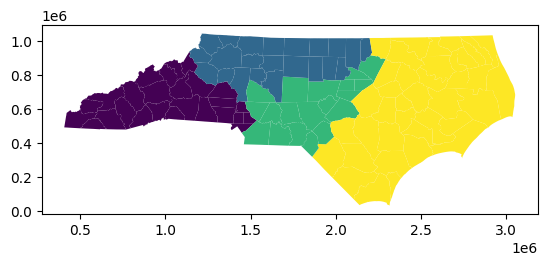

In [72]:
# Which district is each county assigned to?
assignment = [ -1 for u in graph.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = graph.nodes[i]["OBJECTID"]
        
        # Need to find this GEOID in the dataframe
        for u in graph.nodes:
            if geoID == data['OBJECTID'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
data['assignment'] = assignment
my_fig = data.plot(column='assignment').get_figure()

In [73]:
assignments = {i: j for i in graph.nodes for j in range(k) if x[i, j].X > 0.5}

# Initialize counters for each district
total_democrats = {j: 0 for j in range(k)}
total_republicans = {j: 0 for j in range(k)}
total_voters = {j: 0 for j in range(k)}

# Sum up the numbers based on assignments
for i in graph.nodes:
    district_assigned = assignments[i]
    total_democrats[district_assigned] += graph.nodes[i]['num_democrats']
    total_republicans[district_assigned] += graph.nodes[i]['num_republicans']
    total_voters[district_assigned] += graph.nodes[i]['num_democrats'] + graph.nodes[i]['num_republicans']

# Calculate proportions for each district
proportions = {}
for j in range(k):
    if total_voters[j] > 0:  # Prevent division by zero
        sum_dem = total_democrats[j]
        sum_rep = total_republicans[j]
        sum_total = total_voters[j]
        prop_democrats = total_democrats[j] / total_voters[j]
        prop_republicans = total_republicans[j] / total_voters[j]
        proportions[j] = {'Democrats': prop_democrats, 'Republicans': prop_republicans}
        difference = prop_democrats / prop_republicans
    else:
        proportions[j] = {'Democrats': 0, 'Republicans': 0}

# Output the proportions
for j in proportions:
    print(f"District {j}: Democrats: {proportions[j]['Democrats']:.2f}, Republicans: {proportions[j]['Republicans']:.2f}")
    

District 0: Democrats: 0.51, Republicans: 0.49
District 1: Democrats: 0.53, Republicans: 0.47
District 2: Democrats: 0.50, Republicans: 0.50
District 3: Democrats: 0.52, Republicans: 0.48
